In [13]:
from qiskit.quantum_info import Statevector
from qiskit.quantum_info import SparsePauliOp

from susy_qm import calculate_Hamiltonian, ansatze

import pennylane as qml
import numpy as np

In [2]:
potential = 'DW'
cutoff = 4
shots = None

In [3]:
ansatze_type = 'exact' #exact or Reduced
if potential == "QHO":
    ansatz_name = f"CQAVQE_QHO_{ansatze_type}"
elif (potential != "QHO") and (cutoff <= 16):
    ansatz_name = f"CQAVQE_{potential}{cutoff}_{ansatze_type}"
else:
    ansatz_name = f"CQAVQE_{potential}16_{ansatze_type}"

ansatz = ansatze.get(ansatz_name)
num_params = ansatz.n_params

In [15]:
H = calculate_Hamiltonian(cutoff, potential)
eigenvalues = np.sort(np.linalg.eig(H)[0])[:4]
min_eigenvalue = min(eigenvalues.real)

num_qubits = int(1 + np.log2(cutoff))

H_decomp = qml.pauli_decompose(H, wire_order=range(num_qubits))
observables = SparsePauliOp.from_operator(H)

In [10]:
dev = qml.device('default.qubit', wires=num_qubits,shots=None)
@qml.qnode(dev)
def circuit(params):
    ansatz(params, num_qubits)
    return qml.expval(qml.Hermitian(H, wires=range(num_qubits)))

params = [
            0.3966509377256218,
            5.951916764806598,
            6.008466886069231
        ]

print(qml.draw(circuit)(params))
print(min_eigenvalue, circuit(params))

0: ─╭|Ψ⟩─────────────────────┤ ╭<𝓗(M0)>
1: ─├|Ψ⟩──RY(0.40)─╭●────────┤ ├<𝓗(M0)>
2: ─╰|Ψ⟩──RY(5.95)─╰RY(6.01)─┤ ╰<𝓗(M0)>

M0 = 
[[2.375     +0.j 2.47487373+0.j 1.76776695+0.j 0.8660254 +0.j
  0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j]
 [2.47487373+0.j 5.875     +0.j 5.        +0.j 3.06186218+0.j
  0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j]
 [1.76776695+0.j 5.        +0.j 9.375     +0.j 5.51135192+0.j
  0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j]
 [0.8660254 +0.j 3.06186218+0.j 5.51135192+0.j 5.875     +0.j
  0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  1.375     +0.j 1.06066017+0.j 1.76776695+0.j 0.8660254 +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  1.06066017+0.j 4.875     +0.j 3.        +0.j 3.06186218+0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  1.76776695+0.j 3.        +0.j 8.375     +0.j 3.06186218+0.j

In [20]:
qc = ansatze.pl_to_qiskit(ansatz, params=params, num_qubits=num_qubits, reverse_bits=True)

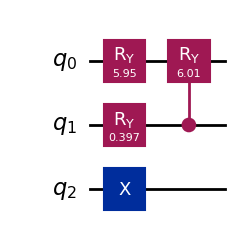

In [21]:
qc.draw('mpl')

In [22]:
state = Statevector.from_instruction(qc)
expectation = state.expectation_value(observables)
expectation

np.complex128(0.9065598714743928+0j)

In [26]:
from qiskit.primitives import StatevectorEstimator

In [27]:
qc = ansatze.pl_to_qiskit(ansatz, params=None, num_qubits=num_qubits, reverse_bits=True)

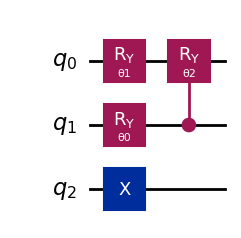

In [28]:
qc.draw('mpl')

In [48]:
estimator = StatevectorEstimator()
pub = (qc, observables, params)
job = estimator.run([pub])
result = job.result()[0]
result.data.evs

array(0.90655987)

In [35]:
from qiskit_aer.primitives import EstimatorV2 as Estimator
from qiskit_aer import AerSimulator
from qiskit.transpiler import generate_preset_pass_manager

In [45]:
exact_estimator = Estimator()
pass_manager = generate_preset_pass_manager(3, AerSimulator())

isa_circuit = pass_manager.run(qc)
pub = (isa_circuit, observables, params)
job = exact_estimator.run([pub])
result = job.result()
pub_result = result[0]
exact_value = float(pub_result.data.evs)
exact_value

1.8179091524699218

In [50]:
est = Estimator()
ev_est = est.run([(qc, observables, params)]).result()[0].data.evs
ev_est

array(1.81790915)

In [43]:
import qiskit_aer
print(qiskit_aer.__version__)


0.17.1
